## 1: Exploratory Data Analysis (EDA)

Processo de Análise e Exploração de dados do dataset: *Credit Card Fraud Detection*.

**Link**: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

---
### 1️⃣ Importando Bibliotecas Necessárias

In [12]:
# Gerenciamento e Visualização dos dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento
from sklearn.preprocessing import StandardScaler, RobustScaler

# Configurações de visualização
%matplotlib inline
sns.set_style('whitegrid')
plt.style.use('seaborn-v0_8-whitegrid')

---
### 2️⃣ Carregando os Dados

In [ ]:
df = pd.read_csv("Data/train.csv")

# Confirmando carregamento do dataset & Verificação do tamanho
train = pd.read_csv('Data/train.csv')  
test = pd.read_csv('Data/test.csv')

print(f"Dados de Treino: {train.shape[0]} linhas e {train.shape[1]} colunas")
print(f"Dados de Teste: {test.shape[0]} linhas e {test.shape[1]} colunas")

Dados de Treino: 227845 linhas e 32 colunas
Dados de Teste: 56962 linhas e 31 colunas


---
### 3️⃣ Análise do Dataset

In [ ]:
# Verificando colunas (labels, tipos de dados, valores nulos)
print(df.info())

# Contagem de valores nulos
print(f"\nValores nulos: ", end=" ")
print(df.isnull().sum().max())

---
#### 💬 Primeira Análise

| Variável | Descrição |
|----------|----------|
| *id* | ID único da transação|
| *Time* | Diferença de tempo em segundos, entre cada transação em relação à primeira transação |
| *Class* | 0 = Não Fraude, 1 = Fraude |
| *Amount* | Valor total da transação |
| *V1 - V28* | Features anônimas|

O dataset tem em sua maior parte dados de números decimais (`float`) e não possui valores ausentes, o que facilita o tratamento, pois não há necessidade de técnicas de preenchimento.

No entanto, as colunas tem labels anônimos, ou seja é preciso de fazer uma visualização estatística e de correlação com o target para entender a importância delas na previsão do modelo.

> Agora vamos verificar o desbalanceamento do dataset.

Distribuição das Classes:

Class
0    227451
1       394
Name: count, dtype: int64

Porcentagem:

Class
0    99.827075
1     0.172925
Name: proportion, dtype: float64



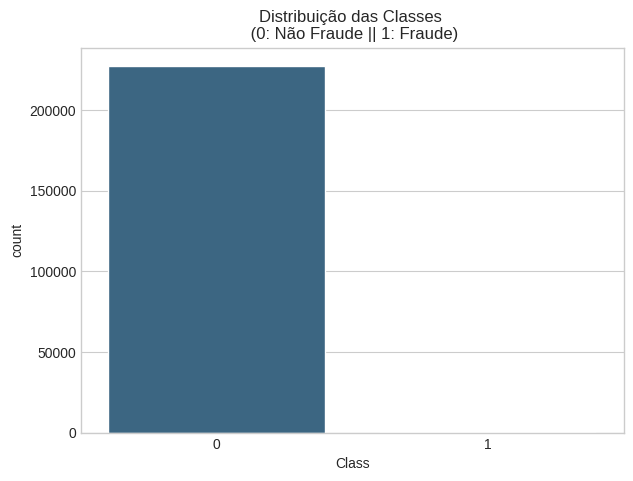

In [22]:
print(f"Distribuição das Classes:\n")
print(df["Class"].value_counts())

print("\nPorcentagem:\n")
print(f"{df["Class"].value_counts(normalize=True) * 100}\n")

# Gráfico
#plt.figure(figsize=(7,5))
sns.countplot(x="Class", data=df, hue="Class", palette='viridis', legend=False)
plt.title(f"Distribuição das Classes \n (0: Não Fraude || 1: Fraude)")
plt.show()

---
#### 💬 Segunda Análise

Como esperado, a fraude é um evento raro. Dessa forma, um modelo "burro" que chutassse sempre em "Não Fraude", conseguiria obter uma acurácia de 99.8%, por esse motivo não podemos utilizar essa métrica como foco na avaliação do modelo.

Será necessario a utilização e comparação de técnicas que lidem com esse desbalanceamento, como *UnderSampling* e *OverSampling*.

> Prosseguindo, vamos verificar a escala das colunas (`Time` & `Amount`) e seus outliers. 

    (As colunas anônimas já estão na mesma escala, como informado no dataset de que elas são resultados da aplicação de PCA)

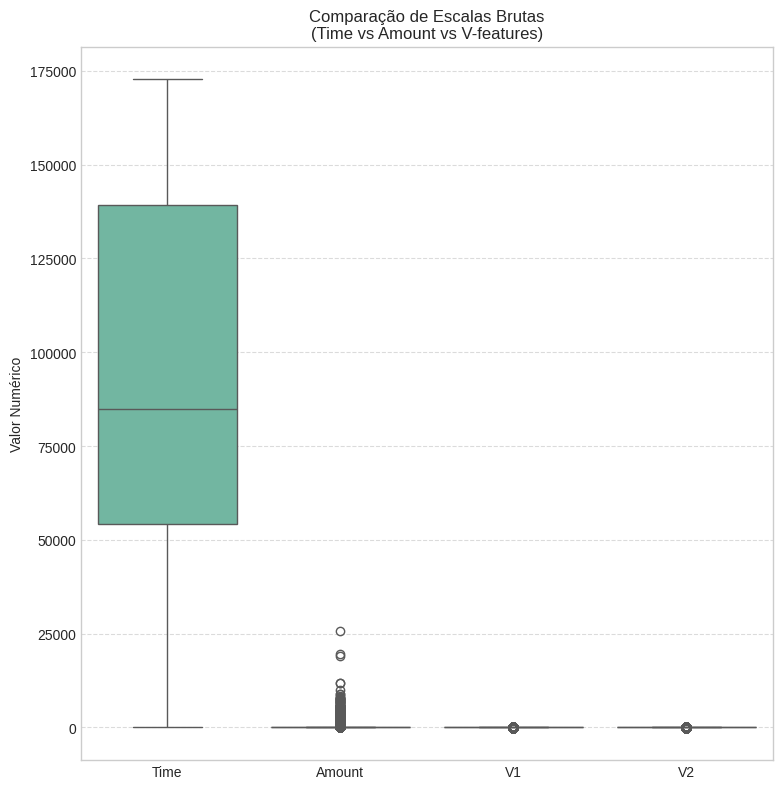

Resumo estatístico das escalas:
               Time        Amount         V1         V2
mean   94885.093704     88.176298   0.000795  -0.000481
std    47488.415034    250.722602   1.958926   1.649092
min        0.000000      0.000000 -56.407510 -72.715728
max   172792.000000  25691.160000   2.451888  22.057729


In [ ]:
plt.figure(figsize=(15, 8))

# 1. Boxplot para comparar as escalas diretamente
plt.subplot(1, 2, 1)
sns.boxplot(data=df[['Time', 'Amount', 'V1', 'V2']], palette="Set2")
plt.title('Comparação de Escalas Brutas \n (Time vs Amount vs V-features)')
plt.ylabel('Valor Numérico')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print("Resumo estatístico das escalas:")
print(df[['Time', 'Amount', 'V1', 'V2']].describe().loc[['mean', 'std', 'min', 'max']])

---
#### 💬 Terceira Análise

A partir do gráfico e do resumo estátistico, podemos confirmar que as features anônimas estão realmente na mesma escala.

Além disso, temos uma ideia sobre quão discrepante estão as colunas `Time` e `Amount`.

- Sendo a `Time` mais uniforme (sem outliers), pois se trata de um contador linear de *0s até 172.792s*, então podemos aplicar um StandardScaler sem problemas.
- Já a `Amount` tem uma alta variação (muitos outliers), perceptível pela grande diferença entre a média e o desvio padrão, sugerindo a aplicação de um RobustScaler.

#### ⛔ Ação importante

Para prosseguir na análise do dataset, e conseguir verificar as correlações das features com a coluna "Class", precisamos criar um **Sub-Sample** que tenha um equilíbrio entre *Fraudes* & *Não Fraudes*.

Assim, podemos pegar todas as 394 fraudes e misturar com 394 não-fraudes aleatórias, e com essa amostra equilibrada, verificar as várias que influenciam na "Class".

In [ ]:
# Embaralhando para garantir aleatoridade na formação do Sub-Sample
df = df.sample(frac=1)

fraud_df = df.loc[df["Class"]==1]
non_fraud_df = df.loc[df["Class"]==0][:394]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Embaralhando novamente e verificando 50/50
new_df = normal_distributed_df.sample(frac=1, random_state=42)
print(f"Distribuição equilibrida: ", end="")
print(new_df["Class"].value_counts(normalize=True))

Distribuição equilibrida: Class
0    0.5
1    0.5
Name: proportion, dtype: float64


> Agora podemos verificar a correlação das variáveis com a coluna "Class"

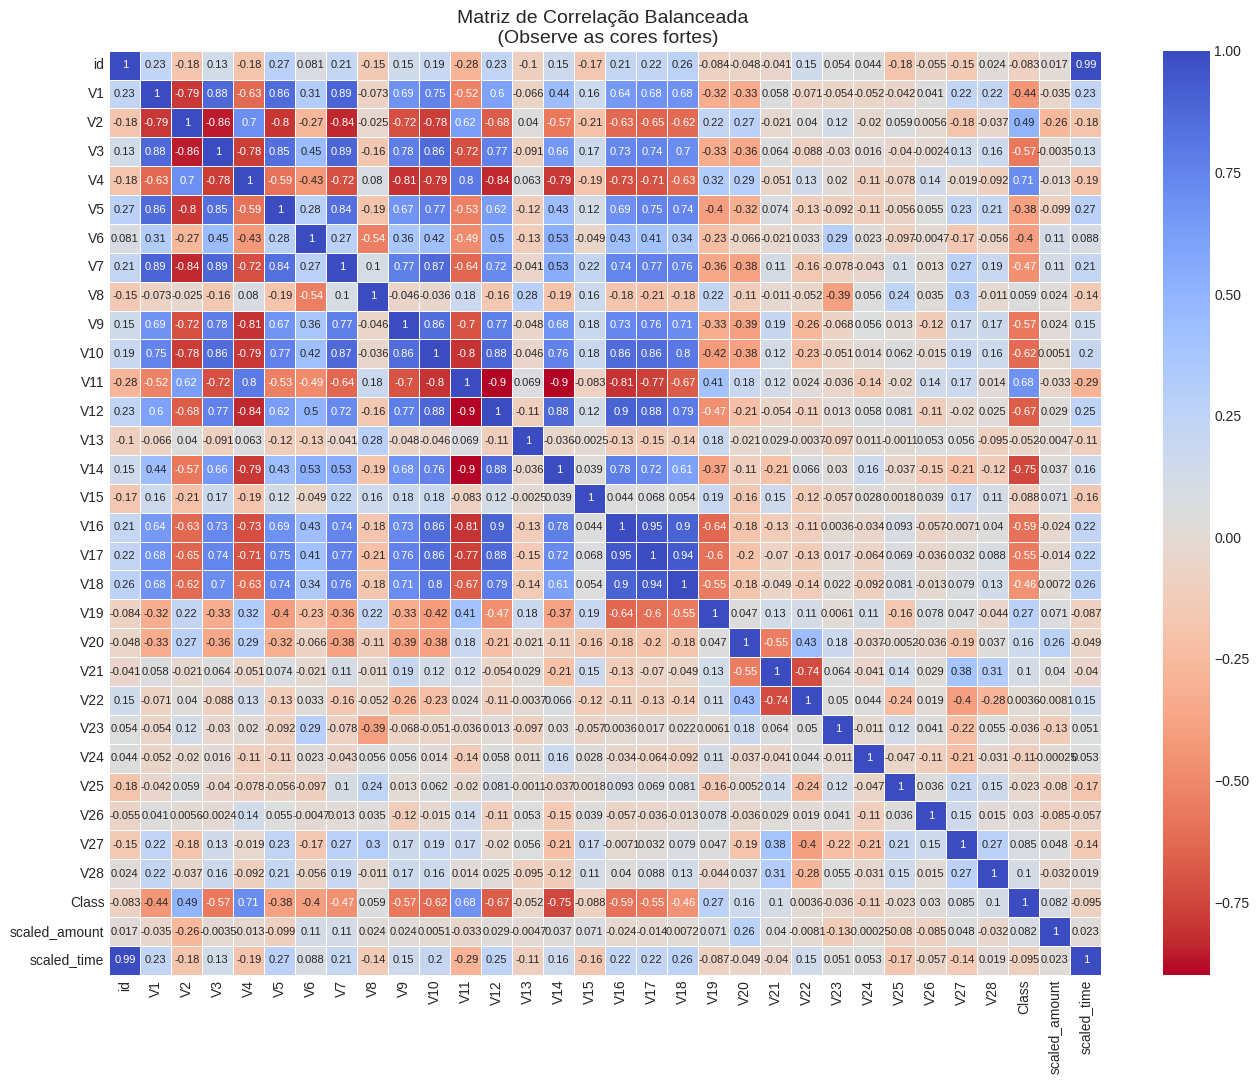

In [42]:
plt.figure(figsize=(16, 12))

"""
Caso queira visualizar como o desbalanceamento afeta as correlações
Correlação no dataset inteiro (desbalanceado)
"""
# corr = df.corr()
# sns.heatmap(corr, cmap='coolwarm_r', annot=True, annot_kws={'size':8}, linewidths=0.5)
# plt.title("Matriz de Correlação Desbalanceada \n (Não use para conclusões)", fontsize=14)

# Correlação no sub-sample (balanceado)
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot=True, annot_kws={'size':8}, linewidths=0.5)
plt.title('Matriz de Correlação Balanceada \n (Observe as cores fortes)', fontsize=14)
plt.show()

---
#### 💬 Quarta Análise

A partir dessa matriz de correlações chegamos em algumas conclusões, sobre as váriaveis anônimas:

- Correlações Positivas: V2, V4, V11, V19 e V20 são as mais positivamente correlacionadas, ou seja, quanto maior seus valores, maior a chance do resultado ser uma fraude.
- Correações Negativas: V3, V9, V10, V12, V14, V16 e V17 são as mais negativamente correlacionadas, ou seja, quanto menor seus valores, maior a chance do resultado ser uma fraude.

É perpetível que algumas correlações tiveram valores extremos, o que pode ser prejudicial para modelos como *Regressão Logística*, por um padrão conhecido, temos que as negativas costumam vir de transações legítimas, por isso é preferível limpar esses pontos, como forma de reduzir **falsos positivos**.

Assim, vamos se concentrar em analisar os outliers extremos das colunas V10, V12 e V14.

> Remover todos os outliers causa uma perda de informação, que pode impactar negativamente na predição do modelo.

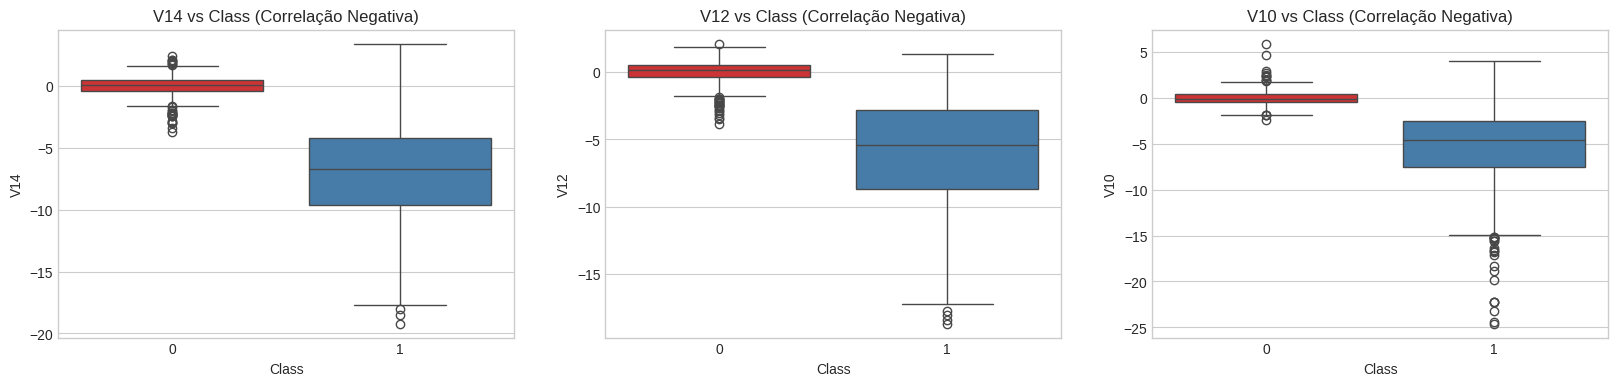

In [44]:
# Visualizando outliers com Boxplot (Exemplo com V14, V12 e V10)
f, axes = plt.subplots(ncols=3, figsize=(20,4))

sns.boxplot(x="Class", y="V14", data=new_df, hue="Class", palette='Set1', ax=axes[0], legend=False)
axes[0].set_title('V14 vs Class (Correlação Negativa)')

sns.boxplot(x="Class", y="V12", data=new_df, hue="Class", palette='Set1', ax=axes[1], legend=False)
axes[1].set_title('V12 vs Class (Correlação Negativa)')

sns.boxplot(x="Class", y="V10", data=new_df, hue="Class", palette='Set1', ax=axes[2], legend=False)
axes[2].set_title('V10 vs Class (Correlação Negativa)')

plt.show()